In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
import datetime

In [2]:
# Visual settings
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
class InflationRiskEngine:
    def __init__(self):
        self.data = None
        self.pca_res = {}
        self.params = {} 
        
        # Configuration
        self.start_date = '2022-03-16' 
        self.end_date = datetime.datetime.today().strftime('%Y-%m-%d')
        self.tickers = {
            '3M': 'DGS3MO', 
            '2Y': 'DGS2', 
            '5Y': 'DGS5', 
            '10Y': 'DGS10', 
            '30Y': 'DGS30'
        }

    def fetch_data(self):
        print(f"\n[1] Fetching Treasury data from FRED ({self.start_date} to Present)...")
        df = web.DataReader(list(self.tickers.values()), 'fred', self.start_date, self.end_date)
        df.rename(columns={v: k for k, v in self.tickers.items()}, inplace=True)
        self.data = df.dropna()
        print(f"    -> Success: Loaded {len(self.data)} trading days from FRED.")

    def run_pca(self):
        if self.data is None: return
        print("\n[2] Running PCA to decompose Yield Curve risk...")
        
        shocks = self.data.diff().dropna()
        pca = PCA(n_components=3)
        pca.fit(shocks)
        
        var = pca.explained_variance_ratio_
        self.pca_res['var'] = var
        self.pca_res['loadings'] = pd.DataFrame(
            pca.components_.T, 
            columns=['Level', 'Slope', 'Curvature'], 
            index=self.data.columns
        )
        
        print(f"    -> Level Risk (PC1):     {var[0]:.1%}")
        print(f"    -> Slope Risk (PC2):     {var[1]:.1%}")
        print(f"    -> Curvature Risk (PC3): {var[2]:.1%}")


    def calibrate_vasicek(self):
        if self.data is None: return
        print("\n[3] Calibrating Vasicek Model...")
        
        # Hybrid Approach
        r_current = self.data['3M'].iloc[-1]
        r_long_term = self.data['10Y'].iloc[-1]
        
        r = self.data['3M'].values
        y = r[1:]
        x = r[:-1]
        
        A = np.vstack([x, np.ones(len(x))]).T
        phi, c = np.linalg.lstsq(A, y, rcond=None)[0]
        
        dt = 1/252
        kappa_hist = (1 - phi) / dt
        resid = y - (phi * x + c)
        sigma = np.std(resid) / np.sqrt(dt)
        
        # Override Theta with Market View
        self.params = {
            'kappa': kappa_hist, 
            'theta': r_long_term, 
            'sigma': sigma
        }
        
        print(f"    -> Calibrated Volatility (Sigma): {sigma:.2f}%")
        print(f"    -> Speed of Reversion (Kappa):    {kappa_hist:.2f}")
        print(f"    -> Long-Term Mean (Theta):        {r_long_term:.2f}%")

    def simulate_forecast(self, horizon=1, paths=10000):
        if not self.params: return

        print(f"\n[4] Simulating {paths} Monte Carlo paths for {horizon} year(s)...")
        dt = 1/252
        steps = int(horizon * 252)
        r0 = self.data['3M'].iloc[-1]
        
        rates = np.zeros((steps, paths))
        rates[0] = r0
        p = self.params
        
        for t in range(1, steps):
            dW = np.random.normal(0, np.sqrt(dt), paths)
            dr = p['kappa'] * (p['theta'] - rates[t-1]) * dt + p['sigma'] * dW
            rates[t] = rates[t-1] + dr
            
        return rates


    def plot_dashboard(self, rates):
        if rates is None: return
        print("\n[5] Generating Risk Dashboard...")
        fig = plt.figure(figsize=(16, 10)) 
        gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.2)
        
        # Chart 1: The Data
        ax0 = plt.subplot(gs[0, 0])
        ax0.plot(self.data.index, self.data['3M'], color='#2c3e50', lw=1.5, label='3M Yield')
        ax0.fill_between(self.data.index, 0, self.data['3M'], color='#e74c3c', alpha=0.1)
        ax0.set_title("1. The Inflation Regime (Fed Lift-off to Present)", fontweight='bold')
        ax0.set_ylabel("Yield (%)")
        ax0.grid(True, alpha=0.3)
        
        # Chart 2: PCA Factors
        ax1 = plt.subplot(gs[0, 1])
        load = self.pca_res['loadings']
        var = self.pca_res['var']
        ax1.plot(load['Level'], marker='o', label=f"Level ({var[0]:.0%})")
        ax1.plot(load['Slope'], marker='o', label=f"Slope ({var[1]:.0%})")
        ax1.plot(load['Curvature'], marker='o', label=f"Curvature ({var[2]:.0%})")
        ax1.axhline(0, color='black', lw=0.5, ls='--')
        ax1.set_title("2. PCA Risk Decomposition", fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Chart 3: Forecast Cone
        ax2 = plt.subplot(gs[1, 0])
        mean_path = np.mean(rates, axis=1)
        days = np.arange(len(mean_path))
        ax2.plot(days, rates[:, :150], color='#e74c3c', alpha=0.03) 
        ax2.plot(days, mean_path, color='black', lw=2, label='Mean Forecast')
        ax2.axhline(self.params['theta'], color='green', ls='--', lw=2, label=f'Equilibrium: {self.params["theta"]:.2f}%')
        ax2.set_title(f"3. 1-Year Rate Forecast", fontweight='bold')
        ax2.grid(True, alpha=0.3)

        # Chart 4: Tail Risk
        ax3 = plt.subplot(gs[1, 1])
        terminal = rates[-1, :]
        sns.histplot(terminal, kde=True, ax=ax3, color='#34495e', stat='density', alpha=0.6, element="step")
        var_99 = np.percentile(terminal, 99)
        es_99 = terminal[terminal > var_99].mean()
        ax3.axvline(var_99, color='orange', ls='--', lw=2, label=f'99% VaR: {var_99:.2f}%')
        ax3.axvline(es_99, color='#c0392b', ls='-', lw=2, label=f'99% ES: {es_99:.2f}%')
        ax3.set_title("4. Tail Risk: VaR vs Expected Shortfall", fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()



[1] Fetching Treasury data from FRED (2022-03-16 to Present)...
    -> Success: Loaded 977 trading days from FRED.

[2] Running PCA to decompose Yield Curve risk...
    -> Level Risk (PC1):     82.0%
    -> Slope Risk (PC2):     10.2%
    -> Curvature Risk (PC3): 6.5%

[3] Calibrating Vasicek Model...
    -> Calibrated Volatility (Sigma): 0.62%
    -> Speed of Reversion (Kappa):    1.39
    -> Long-Term Mean (Theta):        4.09%

[4] Simulating 10000 Monte Carlo paths for 1 year(s)...

[5] Generating Risk Dashboard...


C:\Users\User\AppData\Local\Temp\ipykernel_1536\3109995609.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


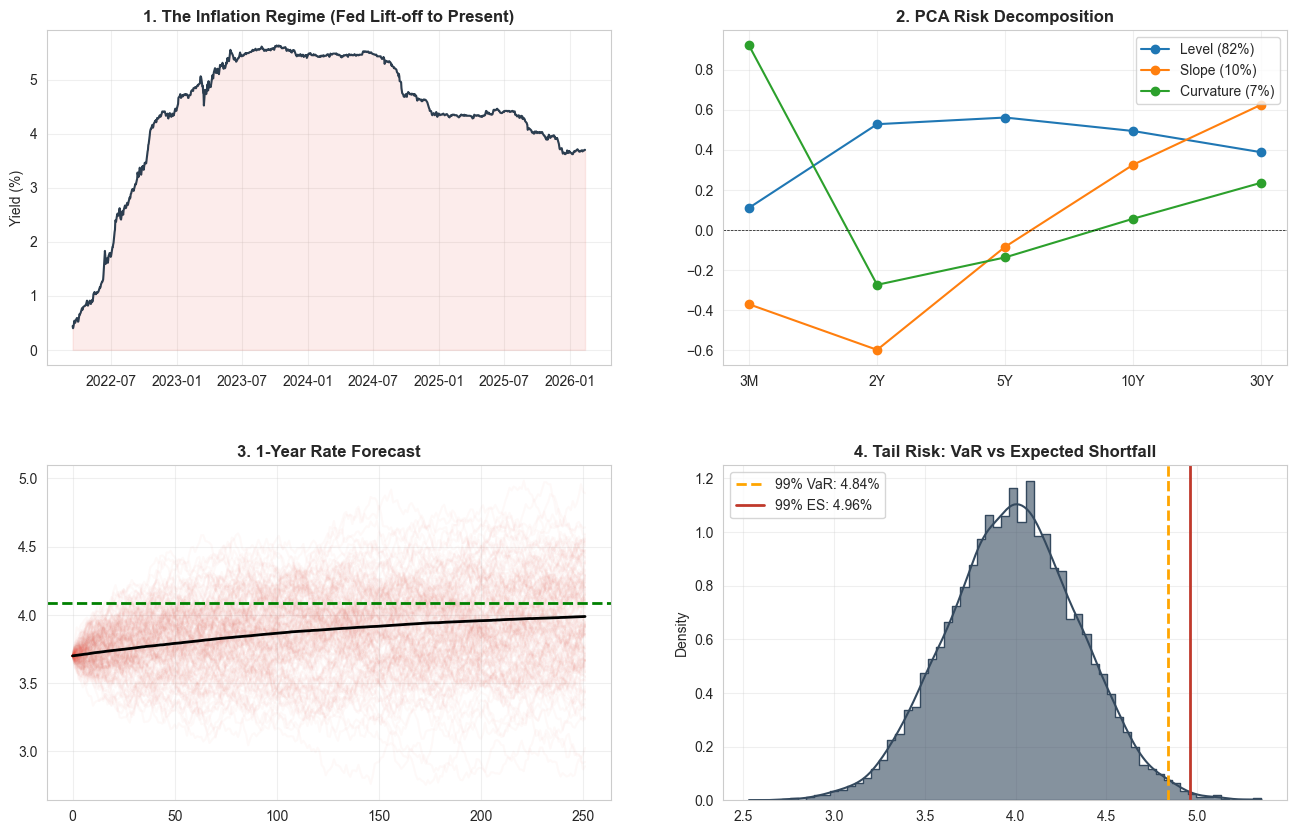

In [4]:
if __name__ == "__main__":
    engine = InflationRiskEngine()
    engine.fetch_data()
    engine.run_pca()
    engine.calibrate_vasicek()
    sim_results = engine.simulate_forecast()
    engine.plot_dashboard(sim_results)